In [1]:
cd ..

/Users/yanndubois/SSL-Risk-Decomposition


In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
#!rm -rf /Users/yanndubois/.cache/torch/hub/YannDubs_SSL-Risk-Decomposition_main

# Collect all results

In [4]:
from torchvision.models import resnet50

In [5]:
import torch
import pandas as pd
from utils.plotting import *
from utils.collect_results import *
from utils.causal import *
import numpy as np
import warnings
import logging
import hubconf

 No module named 'clip'


In [64]:
results = load_all_results(pattern=f"**/seed_*/results_all.csv", 
                           skip_ifneq={}, 
                           skip_ifin=dict(ssl=["swav_rn50w5","selav2_rn50_ep400_2x160_4x96"]))
results = results[results.index.isin(['sk_logistic_hypopt','torch_linear_delta_hypopt'], level=1)]
results = results[["train_test",'train-balsbst-ntrain0.01_test','train-nperclass-5_test']]
assert not (results.groupby("enc").nunique() > 1).any().any()
results = results.groupby("enc").mean()
print("N nan:")
print(results.isna().sum())

Found 803 result files to load.
N nan:
train_test                       13
train-balsbst-ntrain0.01_test     0
train-nperclass-5_test            0
dtype: int64


In [65]:
results[results.isna()["train_test"]]

,train_test,train-balsbst-ntrain0.01_test,train-nperclass-5_test
enc,,,
barlow_rn50_ep300,NaN,50.978,59.556
byol_rn50_bs128,NaN,51.726,59.796
byol_rn50_bs4096,NaN,45.546,54.566
byol_rn50_bs64,NaN,61.304,69.108
dissl_resnet50_dnone_e100_m2,NaN,59.304,68.824
dissl_resnet50_dnone_e100_m2_auglarge,NaN,60.750,70.098
jigsaw_rn50_in22k,NaN,87.380,92.190
pirl_rn50,NaN,64.582,74.202
simclr_resnet50_dnone_e100_m2_data010,NaN,68.194,76.668


In [66]:
metadata_df = hubconf.metadata_df(is_multiindex=False)
check_missing(results, metadata_df)
is_supervised = np.array([metadata_df.loc[i, "ssl_mode"] 
                          for i in results.index.get_level_values(0)]) == "supervised"
results_sup = results[is_supervised]
results_ssl = results[~is_supervised]
metadata = metadata_df.loc[results_ssl.index]

Missing results for: selav2_rn50_ep400_2x160_4x96


In [67]:
melted = pd.melt(results_ssl, var_name="metric", value_vars=results_ssl.columns)

## Std metric

In [68]:
results_ssl.describe()

,train_test,train-balsbst-ntrain0.01_test,train-nperclass-5_test
count,127.000000,139.000000,139.000000
mean,30.291701,51.299827,59.189914
std,9.222337,15.525570,16.255732
min,15.009999,24.776000,27.632000
25%,23.876000,38.331000,46.239000
50%,28.510001,51.172000,60.694000
75%,33.938999,61.349000,70.477000
max,64.186001,90.800000,94.430000


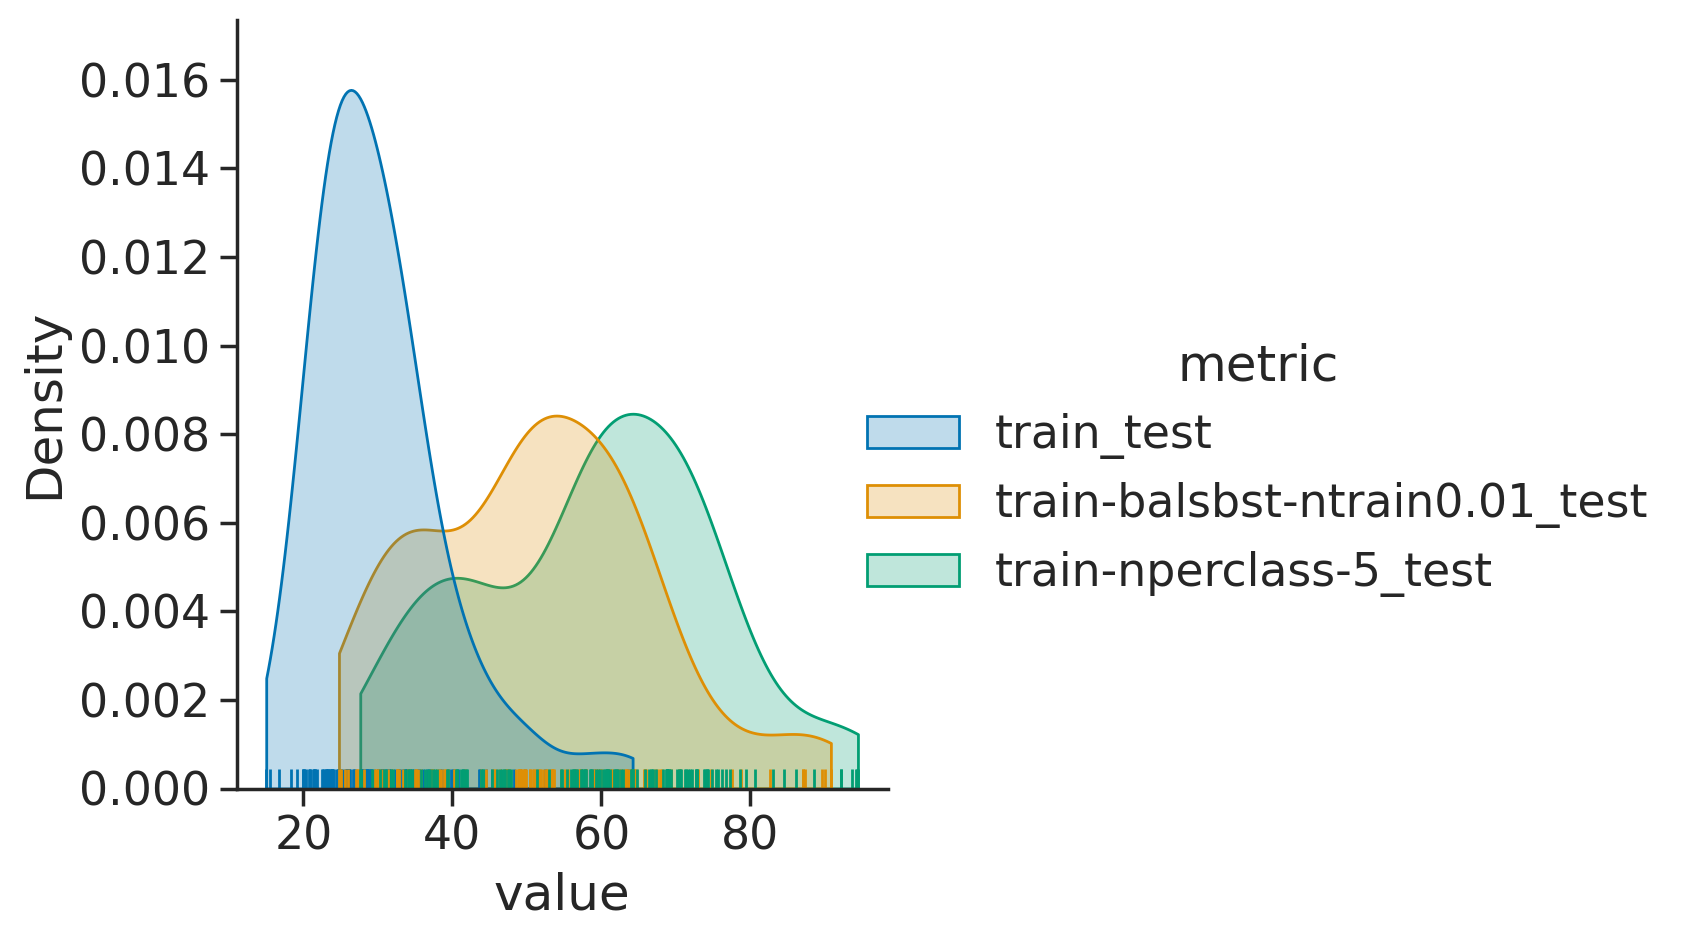

In [69]:
with plot_config():
    sns.displot(melted, x="value", kind="kde", fill=True, cut=0, hue='metric', rug=True)

As a reminder we evaluated all the models in a different way than usually: we do not use augmentations when training the probe for 100% and we perform the hyperparamater tuning on validation for all models. For the case of 100% of imagenet this is orders of magnitude quicker than the standard training. Let's see the difference with standard models

In [70]:
delta = results_ssl.copy()
delta["train_test"] -= (100 - metadata["top1acc_in1k_official"])
delta["train-balsbst-ntrain0.01_test"] -= (100 - metadata["top1acc_in1k-1%_official"])
delta["train-nperclass-5_test"] -= (100 - metadata["top1acc_in1k-c5_official"])

       train_test  train-balsbst-ntrain0.01_test  train-nperclass-5_test
count   92.000000                       9.000000                3.000000
mean     1.081783                       0.265111               -0.344667
std      2.767980                       2.330321                0.475657
min    -17.566000                      -4.272000               -0.854000
25%      0.551500                      -0.350000               -0.561000
50%      1.053999                       0.170000               -0.268000
75%      1.542499                       1.526000               -0.090000
max     10.766001                       4.028000                0.088000


iteritems is deprecated and will be removed in a future version. Use .items instead.


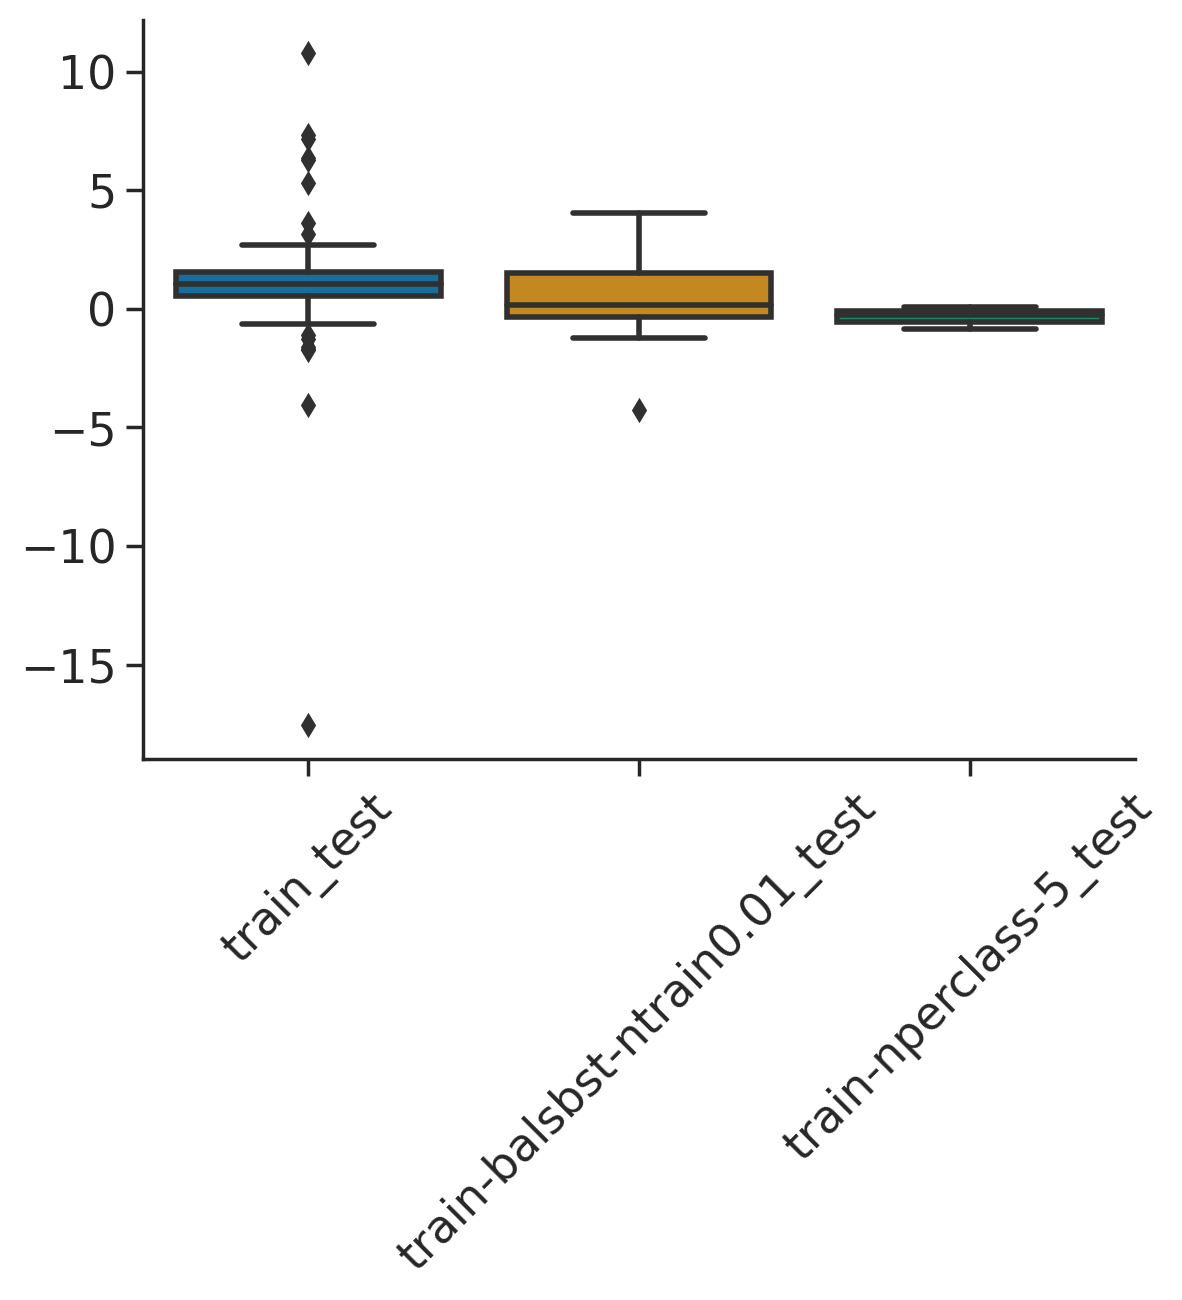

In [71]:
print(delta.describe())
with plot_config():
    ax = sns.boxplot(delta)
    plt.setp(ax.get_xticklabels(), rotation=45)

In [83]:
print("Values that are worst by more than 3%")
delta[(delta > 3).any(axis=1)]

Values that are worst by more than 3%


,train_test,train-balsbst-ntrain0.01_test,train-nperclass-5_test
enc,,,
jigsaw_rn50,10.766001,NaN,NaN
msn_vitl16_ep600,6.359999,NaN,NaN
mugs_vits16_ep800_extracts,-1.710000,4.028,NaN
pirl_rn50_ep200,3.620001,NaN,NaN
relativeloc_rn50_70ep_mmselfsup,3.156001,NaN,NaN
rotnet_rn50_in1k,7.164002,NaN,NaN
rotnet_rn50_in22k,7.314002,NaN,NaN
simclr_rn50_bs256_ep200_mmselfsup,6.275999,NaN,NaN
speccl_bs384_ep100,5.306000,NaN,NaN
